지속적으로 상승, 하락이면 선형성 x 
0 근처에서 왔따갔다

여기서 선형성 안되면 과적합 > 방정식을 다항으로 업그레이드

샤피로 > 데이터 5000건 미만에서 사용

대아토 슈 성ㄱ헌옶안ㄴ 자키베라

상수항은 항상 1!


둘이 결과 다르면 화이트 결과 따르기

독립성 x=-> 시계열...?

리니어 릿지 라소 엘라스틱넷 > 선형성 만족 확인 피료한 알고리즘






# [LAB 06] 지도학습 > 예측 > 선형 > 06-회귀분석의 가정

|조건|설명|
|-|-|
|잔차의 선형성|종속,독립변수의 관계가 선형이다.잔차를 통해 확인|
|잔차의 정규성|오차의 분포가 정규분포를 따른다|
|잔차의 등분산성|오차의 분산이 입력변수와 무관하게 일정하다|
|잔차의 독립성|입력변수와 오차는 관련이 없다|

## #01.준비작업
### [1] 패키지 가져오기


In [1]:
from hossam import *
from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels as sm

from itertools import combinations

#데이터 표준화 모듈
from sklearn.preprocessing import StandardScaler

#선형 회귀 분석 모듈
from sklearn.linear_model import LinearRegression

#훈련/검증 데이터 분리 모듈
from sklearn.model_selection import KFold,cross_val_predict,learning_curve,train_test_split,GridSearchCV

from scipy.stats import pearsonr,spearmanr


#성능 평가 지표 모듈
from sklearn.metrics import(
  r2_score,
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error
)

from scipy.stats import zscore, probplot, shapiro, kstest, jarque_bera
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot as sm_qqplot
import statsmodels.api as sm



### [2] 데이터 가져오기 + 데이터 분할

In [2]:
origin = load_data('fish_processed')


yname = '무게'
x=origin.drop(columns=[yname])

y=origin[yname]

x_train,x_test,y_train,y_test = train_test_split(
  x,y,test_size=0.25,random_state=52
)

x_train.shape,x_test.shape,y_train.shape,y_test.shape

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


((42, 3), (14, 3), (42,), (14,))

### [3] 회귀모델 구축

In [5]:
model=LinearRegression(n_jobs=-1)
param_grid={'fit_intercept' : [True,False] , 'positive' : [True,False]}
gs=GridSearchCV(estimator=model,param_grid=param_grid , cv=5 , scoring = 'r2',n_jobs=-1)
gs.fit(x_train ,y_train)

estimator = gs.best_estimator_
estimator

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",True


## #02.잔차 구하기
- 선형회귀의 가설 확인은 모형이 이론적으로 타당한지 확인하는 단계
- 학습 과정 자체를 설명하는 조건
- 따라서 모형을 학습시킨 데이터 기준으로 확인해야함

In [6]:
rdf = x_train.copy()
rdf[yname] = y_train


#예측치
rdf['y_pred'] = estimator.predict(x_train)


#잔차
rdf['resid'] = rdf[yname] - rdf['y_pred']

rdf.head()

,길이,높이,두께,무게,y_pred,resid
19,-0.603177,-0.701884,-0.639841,4.875197,4.829781,0.045416
37,0.548851,0.759978,0.724503,6.244167,6.030390,0.213776
40,0.962686,1.057959,1.202024,6.530878,6.461677,0.069200
6,-1.028197,-0.933258,-0.924079,4.369448,4.386838,-0.017390
24,-0.435406,-0.200574,-0.582993,5.420535,5.004627,0.415908


## #03.잔차의 선형성
### [1] 시각화를 통한 확인

예측값에 따른 잔차에 대한 산점도 + 추세선 그래프를 그린다
모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 한다
빨간 실선은 잔차의 추세를 의미하며, 빨간 실선이 점선에서 크게 벗어나면 잔차가 크게 달라진다는 뜻
즉, 선형성이 없음을 의미
sklearn 에는 RESET 검정이 없으므로 statsmodles로 동일 데이터를 다시 재적합해서 검정하거나 시각화 결과만을 가지고 판별해야한다

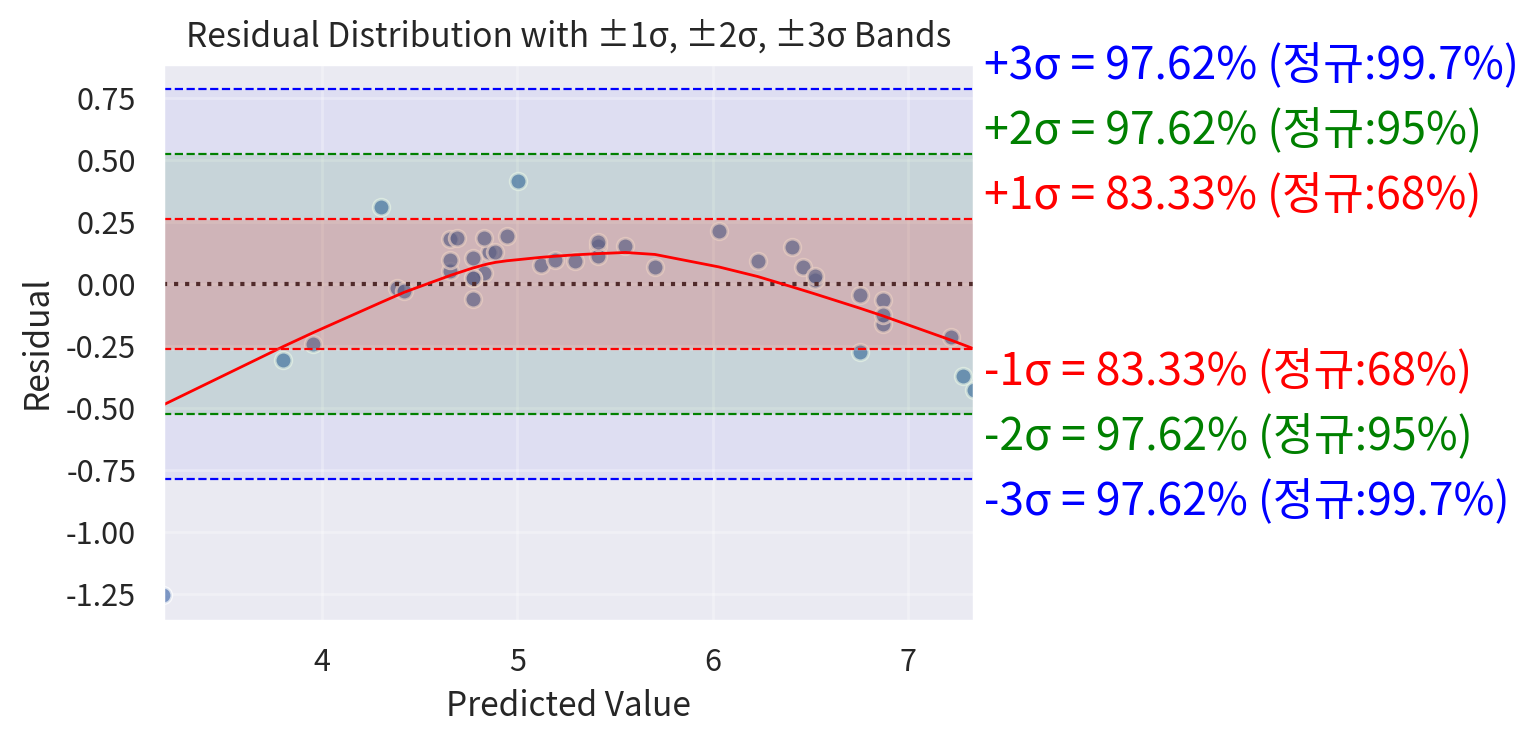

In [7]:
y = rdf[yname].values
y_pred = rdf["y_pred"].values
resid = rdf["resid"].values

figsize = (1600 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 잔차 산점도
sb.residplot(
    x=y_pred,
    y=resid,
    lowess=True,  # 잔차 추세선 표시
    line_kws={"color": "red", "linewidth": 1},  # 추세선 스타일
    scatter_kws={"edgecolor": "white", "alpha": 0.7},
    ax=ax
)

# RMSE 계산
mse_val = mean_squared_error(y, y_pred)
mse_sq = np.sqrt(mse_val)

# ±1σ, ±2σ, ±3σ 안에 들어오는 비율
r1 = resid[(resid > -mse_sq) & (resid < mse_sq)].size / resid.size * 100
r2 = resid[(resid > -2 * mse_sq) & (resid < 2 * mse_sq)].size / resid.size * 100
r3 = resid[(resid > -3 * mse_sq) & (resid < 3 * mse_sq)].size / resid.size * 100
mse_r = [r1, r2, r3]

xmin, xmax = ax.get_xlim()

# 구간 배경 색상
colors = ["red", "green", "blue"]
alphas = [0.15, 0.10, 0.05]

# 3σ 영역 (가장 바깥)
ax.axhspan(-3 * mse_sq, 3 * mse_sq, facecolor=colors[2], alpha=alphas[2], zorder=0)
# 2σ 영역
ax.axhspan(-2 * mse_sq, 2 * mse_sq, facecolor=colors[1], alpha=alphas[1], zorder=1)
# 1σ 영역
ax.axhspan(-mse_sq, mse_sq, facecolor=colors[0], alpha=alphas[0], zorder=2)

# 경계선
for i, c in enumerate(colors):
    ax.axhline(mse_sq * (i + 1), color=c, linestyle="--", linewidth=0.8)
    ax.axhline(-mse_sq * (i + 1), color=c, linestyle="--", linewidth=0.8)

# 이론적 정규분포 기준 비율
target = [68, 95, 99.7]

for i, c in enumerate(colors):
    ax.text(
        x=xmax + 0.05,
        y=(i + 1) * mse_sq,
        s=f"+{i+1}σ = {mse_r[i]:.2f}% (정규:{target[i]}%)",
        color=c,
        va="bottom"
    )
    ax.text(
        x=xmax + 0.05,
        y=-(i + 1) * mse_sq,
        s=f"-{i+1}σ = {mse_r[i]:.2f}% (정규:{target[i]}%)",
        color=c,
        va="top"
    )

ax.set_title("Residual Distribution with ±1σ, ±2σ, ±3σ Bands")
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


> 0을 기준으로 골고루 퍼져있지 않아 선형성을 만족하지 않음을 알 수 있다

## #04.정규성 검정
### [1] 시각화를 통한 확인 Q-Q Plot
statmodels 의 QQ PLOT 사용
- line(str) 참조선의 유형 , 기본값 's' (standardized)
- s : 표본의 표준편차와 평균을 기반으로 조정된 선
- r : 실제 점들에 대한 회귀선 (데이터 추세 반영)
- q : 1사분위수와 3사분위수를 통과하는 선
- 45: 45도 대각선

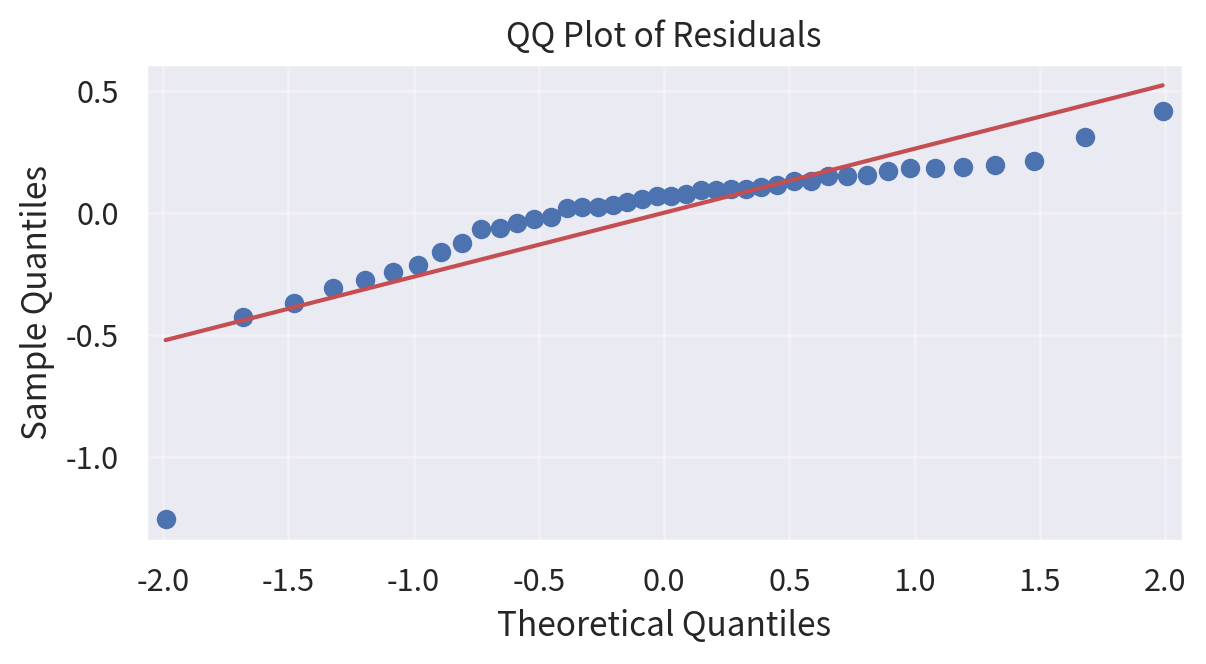

In [8]:
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# statsmodels QQ plot 사용 (잔차 정규성 확인)
sm_qqplot(rdf["resid"], line="s", ax=ax)

ax.set_title("QQ Plot of Residuals")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


### [2] 통계량을 통한 확인

In [10]:
residuals = rdf["resid"].values
n = len(residuals)
alpha = 0.05
results = []


In [11]:
#1. Shapiro–Wilk 검정 (표본 5000개 미만일 때 추천)
if n < 5000:
    try:
        stat_sw, p_sw = shapiro(residuals)
        significant_sw = p_sw <= alpha

        if significant_sw:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f} <= {alpha})"
        else:
            interpretation_sw = f"정규성 만족 (p={p_sw:.4f} > {alpha})"

        results.append(
            {
                "검정": "Shapiro-Wilk",
                "검정통계량": f"{stat_sw:.4f}",
                "p-value": f"{p_sw:.4f}",
                "유의수준": alpha,
                "정규성_위반": significant_sw,
                "해석": interpretation_sw,
            }
        )
    except Exception:
        pass

#2. Jarque–Bera 검정 (항상 수행)
try:
    stat_jb, p_jb = jarque_bera(residuals)
    significant_jb = p_jb <= alpha

    if significant_jb:
        interpretation_jb = f"정규성 위반 (p={p_jb:.4f} <= {alpha})"
    else:
        interpretation_jb = f"정규성 만족 (p={p_jb:.4f} > {alpha})"

    results.append(
        {
            "검정": "Jarque-Bera",
            "검정통계량": f"{stat_jb:.4f}",
            "p-value": f"{p_jb:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_jb,
            "해석": interpretation_jb,
        }
    )
except Exception:
    pass


In [12]:
result_df = DataFrame(results)
result_df


,검정,검정통계량,p-value,유의수준,정규성_위반,해석
0,Shapiro-Wilk,0.7584,0.0000,0.05,True,정규성 위반 (p=0.0000 <= 0.05)
1,Jarque-Bera,227.5577,0.0000,0.05,True,정규성 위반 (p=0.0000 <= 0.05)


## #03 등분산성 검정

In [ ]:
resid = rdf["resid"]
alpha = 0.05
results = []

# 독립변수 행렬 (상수항 포함)
exog = rdf.drop(columns=[yname, "y_pred", "resid"])
exog = sm.add_constant(exog)


In [14]:
# 1. Breusch–Pagan 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
    significant_bp = lm_pvalue <= alpha

    if significant_bp:
        interpretation_bp = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_bp = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "Breusch-Pagan",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성 위반": significant_bp,
            "해석": interpretation_bp,
        }
    )
except Exception:
    pass


# 2. White 검정
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_white(resid, exog)
    significant_white = lm_pvalue <= alpha

    if significant_white:
        interpretation_white = f"등분산성 위반 (p={lm_pvalue:.4f} <= {alpha})"
    else:
        interpretation_white = f"등분산성 만족 (p={lm_pvalue:.4f} > {alpha})"

    results.append(
        {
            "검정": "White",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value": f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성 위반": significant_white,
            "해석": interpretation_white,
        }
    )
except Exception:
    pass


result_df = DataFrame(results)
result_df

,검정,검정통계량 (LM),p-value,유의수준,등분산성 위반,해석
0,Breusch-Pagan,5.4397,0.1423,0.05,False,등분산성 만족 (p=0.1423 > 0.05)
1,White,26.5848,0.0016,0.05,True,등분산성 위반 (p=0.0016 <= 0.05)


| 구분    | Breusch–Pagan    | White           |
| ----- | ---------------- | --------------- |
| 가정    | 분산이 **선형적으로** 변함 | 분산 형태 **제약 없음** |
| 민감도   | 낮음               | **매우 높음**       |
| 검정 대상 | 단순 이질분산          | **비선형·상호작용 포함** |
| 실무 성향 | 보수적              | 공격적             |


- 단순한 이질분산은 없음 (BP 통과)
- 복잡한 형태의 이질분산은 존재 가능 (White 탈락)
- White 검정이 더 일반적이므로, 위반 쪽으로 해석하는 게 안전
- 혹은 BP는 통과했으나 White 검정에서 등분산성 위반이 관측되어 강한 등분산성 가정은 성립하지 않는 것으로 판단

✅ 정리: BP는 단순 이질분산만 보고, White는 복잡한 이질분산까지 본다. 둘이 다르면 White 결과를 따른다.

## #04.잔차의 독립성
Durbin–Watson 통계량을 확인한다.

| 수치 | 해석                       |
| -: | ------------------------ |
|  0 | 잔차들이 **양의 상관관계** (독립성 X) |
|  2 | 잔차들이 **독립**              |
|  4 | 잔차들이 **음의 상관관계** (독립성 X) |

일반적으로 DW값이 1.5 ~ 2.5 범위에 있으면 독립으로 판단

In [15]:
# Durbin-Watson 통계량 계산
dw_stat = durbin_watson(rdf["resid"])

# 자기상관 판단 (1.5 < DW < 2.5 범위를 독립성 만족으로 판단)
is_autocorrelated = dw_stat < 1.5 or dw_stat > 2.5

# 해석 메시지 생성
if dw_stat < 1.5:
    interpretation = f"DW={dw_stat:.4f} < 1.5 (양의 자기상관)"
elif dw_stat > 2.5:
    interpretation = f"DW={dw_stat:.4f} > 2.5 (음의 자기상관)"
else:
    interpretation = f"DW={dw_stat:.4f} (독립성 가정 만족)"

# 결과 데이터프레임 생성
result_df = DataFrame(
    {
        "검정": ["Durbin-Watson"],
        "검정통계량(DW)": [dw_stat],
        "독립성_위반": [is_autocorrelated],
        "해석": [interpretation],
    }
)

result_df


,검정,검정통계량(DW),독립성_위반,해석
0,Durbin-Watson,1.817228,False,DW=1.8172 (독립성 가정 만족)


## #05.가정에 위배되면?

가정 하나라도 위반되면 회귀를 버리는 것이 아니라
👉 모형을 보정하거나 적절한 대안을 선택하는 것이 올바른 대응이다.

| 위반 가정       | 문제 의미                             | 어떻게 확인하나?              | 해결 방법                                                  |
| ----------- | --------------------------------- | ---------------------- | ------------------------------------------------------ |
| **선형성 위반**  | X와 Y의 관계가 직선이 아님                  | 잔차 vs 적합값 그래프에서 곡선 패턴  | ① 변수 변환 (log, sqrt 등)<br>② 다항항 추가 (x² 등)<br>③ 상호작용항 추가 |
| **정규성 위반**  | 잔차가 정규분포를 따르지 않음 → p-value 신뢰도 감소 | QQ-plot / Shapiro-Wilk | ① Y 변환 (log, sqrt)<br>② 표본이 충분히 크면(>30) 큰 문제 아님        |
| **독립성 위반**  | 잔차가 서로 상관됨 (특히 시계열 데이터)           | Durbin-Watson          | ① 추세·시간 변수 추가 (예: t)<br>② 시계열 모형으로 전환 필요               |
| **등분산성 위반** | 잔차 분산이 일정하지 않음 → 계수 해석 불안정        | 잔차 vs 적합값 그래프에서 부채꼴 모양 | ① Y 변환 (log, sqrt) ← 가장 효과적<br>② 표본이 충분히 크면(>30) 문제 완화 |


## #06. 가정에 위배된 상태로 그냥 두면? 

가정 위반 → 영향 범위에 따라 해석이 제한됨
→ 구조는 분석 결과로 보고, 통계적 신뢰 해석은 조심해야 함

✏️ [1] 선형성 가정 위반
잔차 분석 결과, 일부 독립변수와 종속변수 간 관계가 완전한 선형성을 만족하지 못함
이로 인해 회귀계수는 선형 근사(linear approximation) 수준의 해석만 가능
계수의 정확한 함수 형태 해석은 어려움

✏️ [2] 정규성 가정 위반
잔차가 정규분포를 따르지 않으면
👉 계수 추정 자체는 유효하지만
👉 p-value 기반 유의성 검정의 신뢰도는 낮아짐

유의성 판단에 제약 발생

⚠️ [3] 독립성 가정 위반 (가장 중요!)
잔차 간 자기상관 존재 → 독립성 가정 불충족
표준오차가 과소 또는 과대 추정될 가능성
유의성 판단과 신뢰구간 해석에 제한 발생
하지만 계수의 방향성 해석은 가능

✏️ [4] 등분산성 가정 위반
잔차 분산이 일정하지 않아 등분산성 가정 불충족
계수의 표준오차 추정이 왜곡되어 통계량의 신뢰성 저하
비교·검정 목적의 해석에 제약
예측 정확도 자체는 유지 가능

📌 최종 정리
본 분석은 선형회귀모형을 적용했으나,
일부 가정(선형성, 독립성, 등분산성)이 완전히 충족되지 않았다.

따라서
✔ 회귀계수의 부호와 상대적 영향력 해석은 가능하지만
⚠ 통계적 유의성 검정과 신뢰구간 해석에는 제한이 있다.